In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import methyltree 
import methscan
from tqdm import tqdm
import scipy.stats as stats
import scanpy as sc
import cospar as cs
import yaml
from matplotlib import cbook, cm, colors, rcParams
sns.set_style('white')
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
rcParams["font.size"] = 13
# %config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

cs.settings.set_figure_params()

In [2]:
current_directory = os.getcwd()

data_path=f'{current_directory}/metadata/mouse_LK_all/downstream_R/all_data'
df_sample=methyltree.metadata.update_samples_from_config(data_path)


with open(f'{data_path}/../../config.yaml', 'r') as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
    if 'reference' not in yaml_data['bismark']:
        genome_reference='mm10'
    else:
        genome_reference=yaml_data['bismark']['reference']
        
    if genome_reference=='mm10':
        profile_annotation='prom_2000_2000'
        ref_prefix=''
    else:
        ref_prefix=f'{genome_reference}_'
        profile_annotation=f'{genome_reference}_prom_2000_2000'
        
    selection_list=yaml_data['SampleList']
        
    if 'protocol' not in yaml_data.keys():
        protocol='BSseq' # or cabernet
    else:
        protocol=yaml_data['protocol']
        
    if 'mapping_mode' not in yaml_data['bismark'].keys():
        mapping_mode='SE'
    else:
        mapping_mode=yaml_data['bismark']['mapping_mode']
        
    print(f'Protocol: {protocol}')
    print(f'Genome reference: {genome_reference}')
    print(f'Profile annotation: {profile_annotation}')
    print(f'Mapping mode: {mapping_mode}')
    

if 'public_BS_data/' in data_path:
    folder_name=data_path.split('public_BS_data/')[1].split('/')[0]
else:
    folder_name=data_path.split('/')[-4]
    
if 'library_name' in yaml_data.keys():
    library_name = yaml_data['library_name']
    print(f'Library name: {library_name}')
else:
    print('Libary_name not found!')

print(f'Folder name: {folder_name}') 
print(f'data_path: {data_path}')
out_dir=f'{data_path}/out_dir'
compact_file_dir=f'{out_dir}/compact_data'

Initialize sample info
old_samples: 576; config samples: 576; merged samples: 576
Protocol: BSseq
Genome reference: mm10
Profile annotation: prom_2000_2000
Mapping mode: SE
Libary_name not found!
Folder name: metadata
data_path: /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data


# Quality checking

## Mapping efficiency

Note that the absolute value is wrong. This can add up over 100. The 3 mapping efficiency cannot be simply added up. 

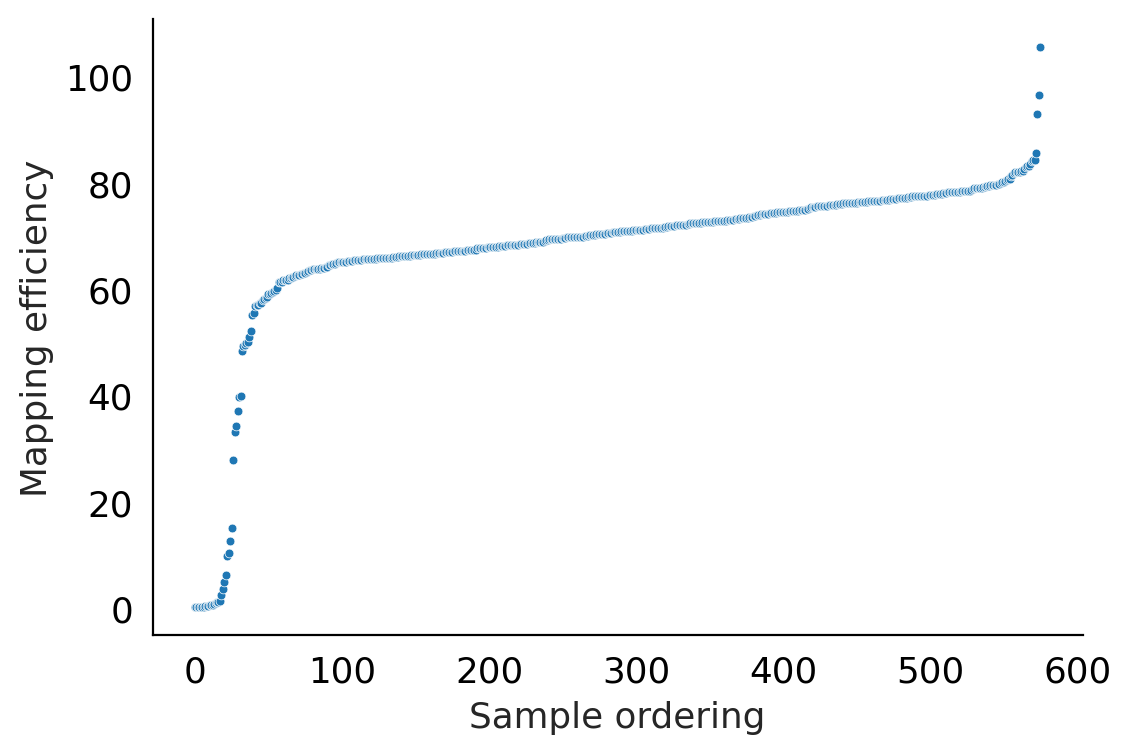

In [3]:
import importlib
from methyltree import quality_control
importlib.reload(quality_control)

df_mapping = quality_control.QC_mapping_efficiency(data_path, mapping_mode='SE',genome_reference=genome_reference)
df_mapping = df_mapping.drop_duplicates()

## Generate compact data for fast access 
(need to be done only once, regardless of which annotation you use)

In [27]:
len(selected_sample_list)

576

In [4]:
#selected_sample_list=list(df_sample['sample'].unique())
selected_sample_list=list(df_sample['sample'].unique())
input_files=[f'{data_path}/met/cpg_level/{x}.tsv.gz' for x in selected_sample_list]
recompute=False
# compact the data
if (not os.path.exists(f'{compact_file_dir}/chr1.npz')) or recompute:
    methscan.prepare.prepare(input_files,compact_file_dir,input_format='1:2:3:4u:\t:1',round_sites=True,chunksize=1e7)
    # smooth the data (we do not need this, but this is required by this package)
    methscan.smooth.smooth(compact_file_dir,bandwidth=1000, use_weights=True)
    
if os.path.exists(f'{compact_file_dir}/1.npz'):
    raise ValueError('chromosome name in cpg_level files should be changed to chr1 format')

## Profile_only_met

In [5]:
region_dir=f"{current_directory}/metadata/mouse_LK_all/bed_files/{profile_annotation}.bed"
recompute=False
TSS_file=f'{data_path}/results/TSS.csv'
if (not os.path.exists(TSS_file)) or recompute:
    with gzip.open(region_dir,'rt') as regions:
        next(regions)  # 跳过标题行
        with open(TSS_file,'w') as output:
            methscan.profile.profile(compact_file_dir, regions, output, width=4000, strand_column=4, label=None)
df_TSS=pd.read_csv(TSS_file,sep=',')
window_size=25
df_TSS['position_coarse']=df_TSS['position'].apply(lambda x: 10*(x//window_size))
df_TSS_new=df_TSS.groupby(['position_coarse','cell','cell_name']).apply(lambda x: np.mean(x['meth_frac'])).reset_index().rename(columns={0:'meth_frac'})

In [6]:
import numpy as np
def compute_TSS_score(x):
    return np.corrcoef(abs(x['position_coarse'].to_numpy()),x['meth_frac'].to_numpy())[0,1]
    
df_stats=pd.read_csv(f'{compact_file_dir}/cell_stats.csv')
df_stats.columns=['sample','nCG','n_meth','met_rate']
df_stats['TSS_score']=np.array(df_TSS_new.groupby('cell').apply(compute_TSS_score))

In [7]:
df_stats

,sample,nCG,n_meth,met_rate,TSS_score
0,LK_DNA_1_A1,5823675,4095711,0.703286,0.923478
1,LK_DNA_1_A10,4263579,3009624,0.705891,0.922159
2,LK_DNA_1_A11,3621097,2649970,0.731814,0.917180
3,LK_DNA_1_A12,3732135,2347085,0.628885,0.933875
4,LK_DNA_1_A2,3555247,2637749,0.741931,0.924622
...,...,...,...,...,...
571,LK_DNA_6_H5,5418277,3722361,0.687001,0.920856
572,LK_DNA_6_H6,5426532,3677126,0.677620,0.918820
573,LK_DNA_6_H7,3341204,2177420,0.651687,0.924902
574,LK_DNA_6_H8,4213937,2892398,0.686389,0.922848


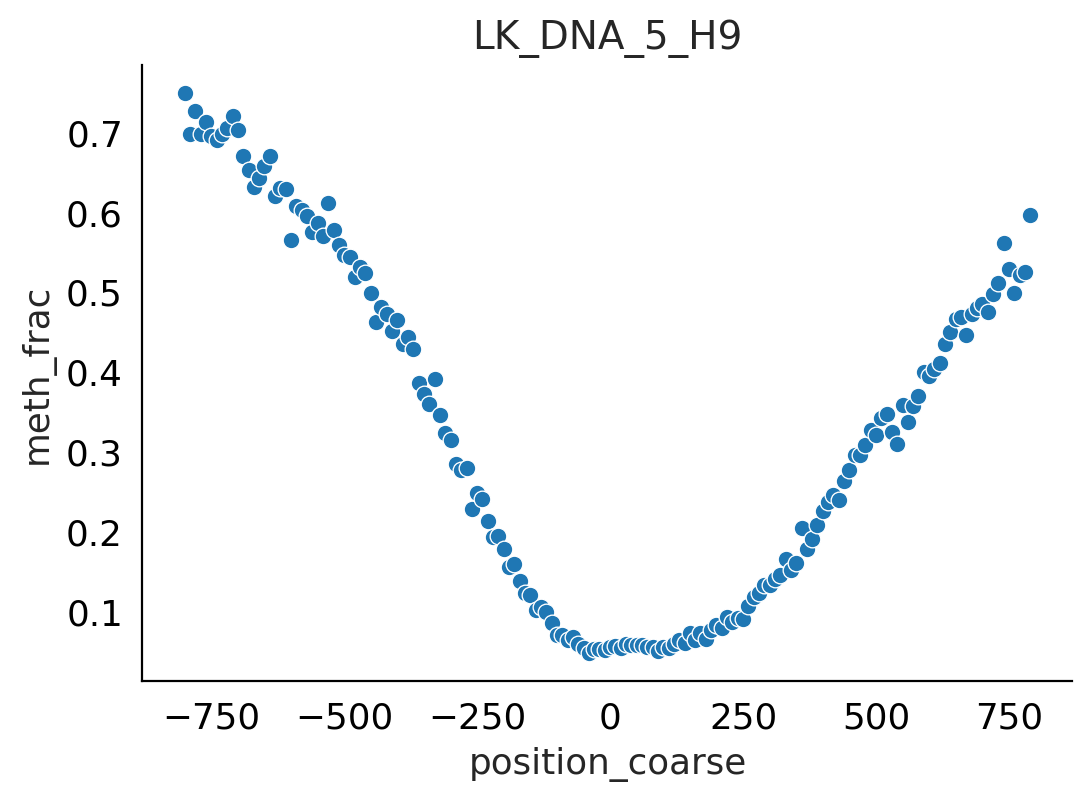

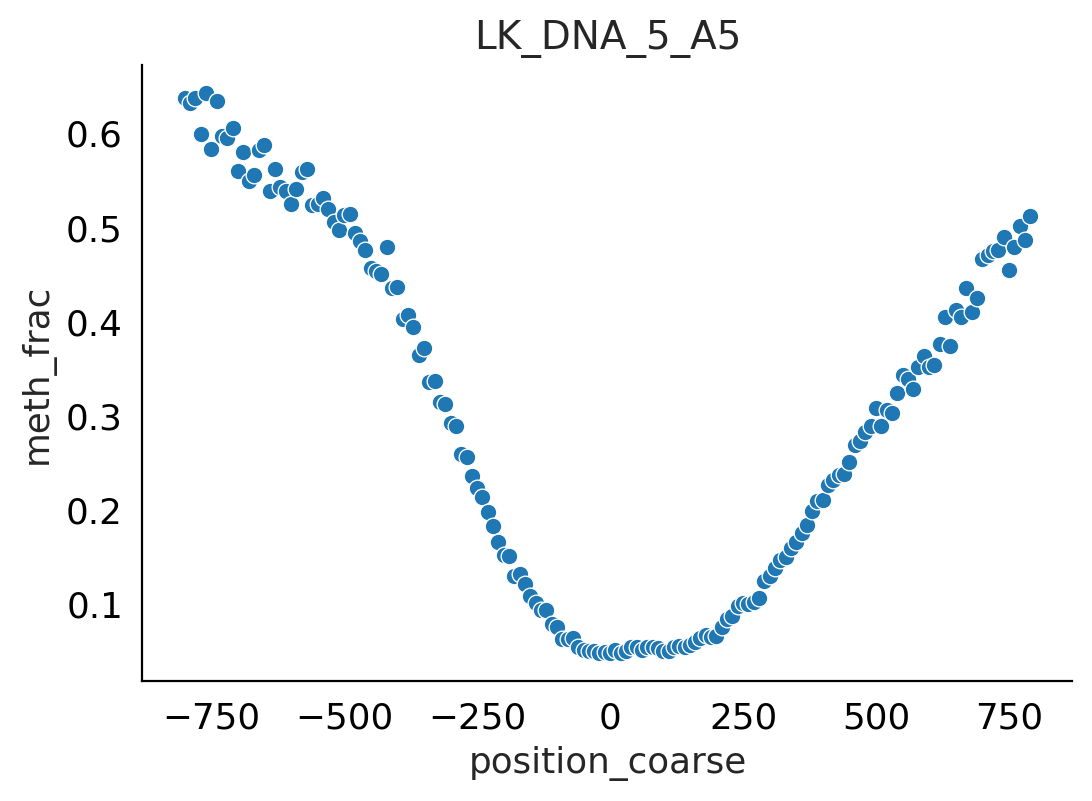

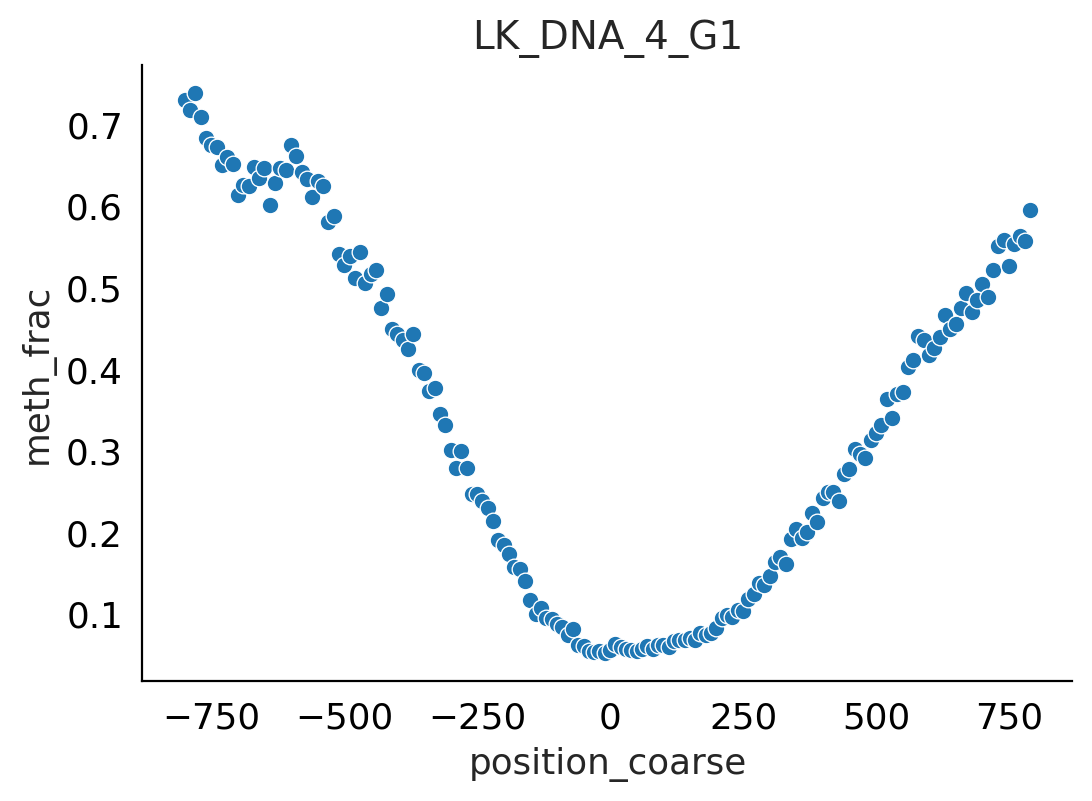

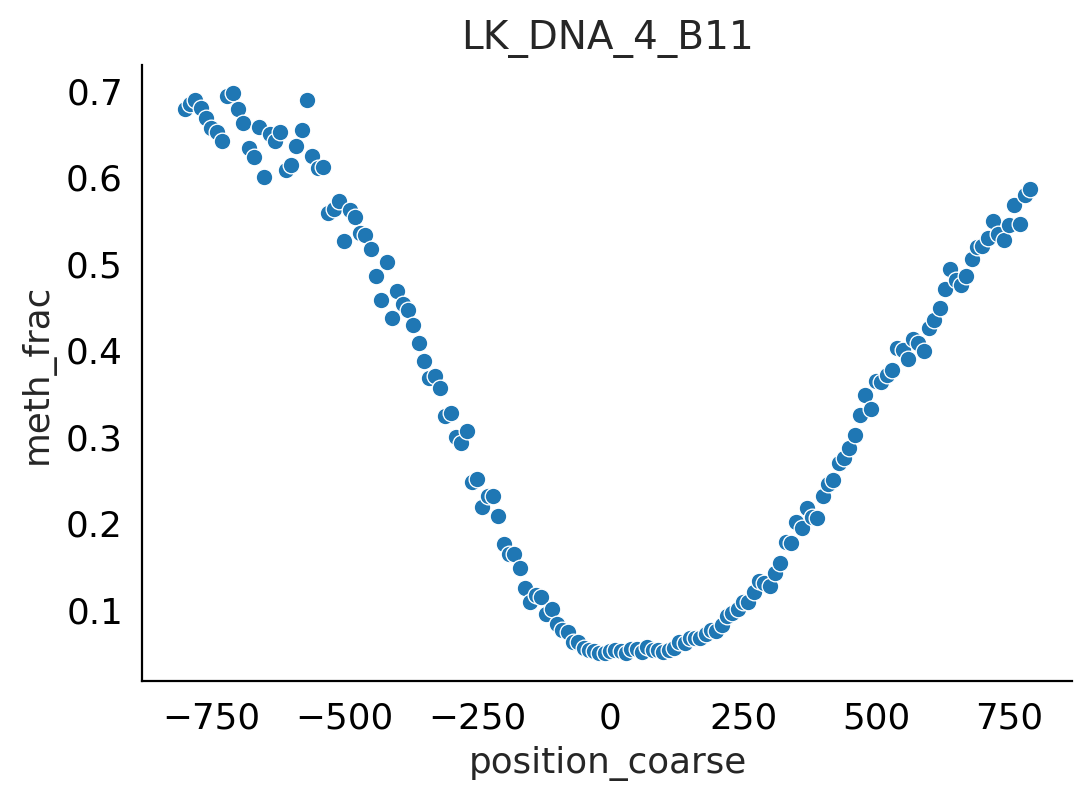

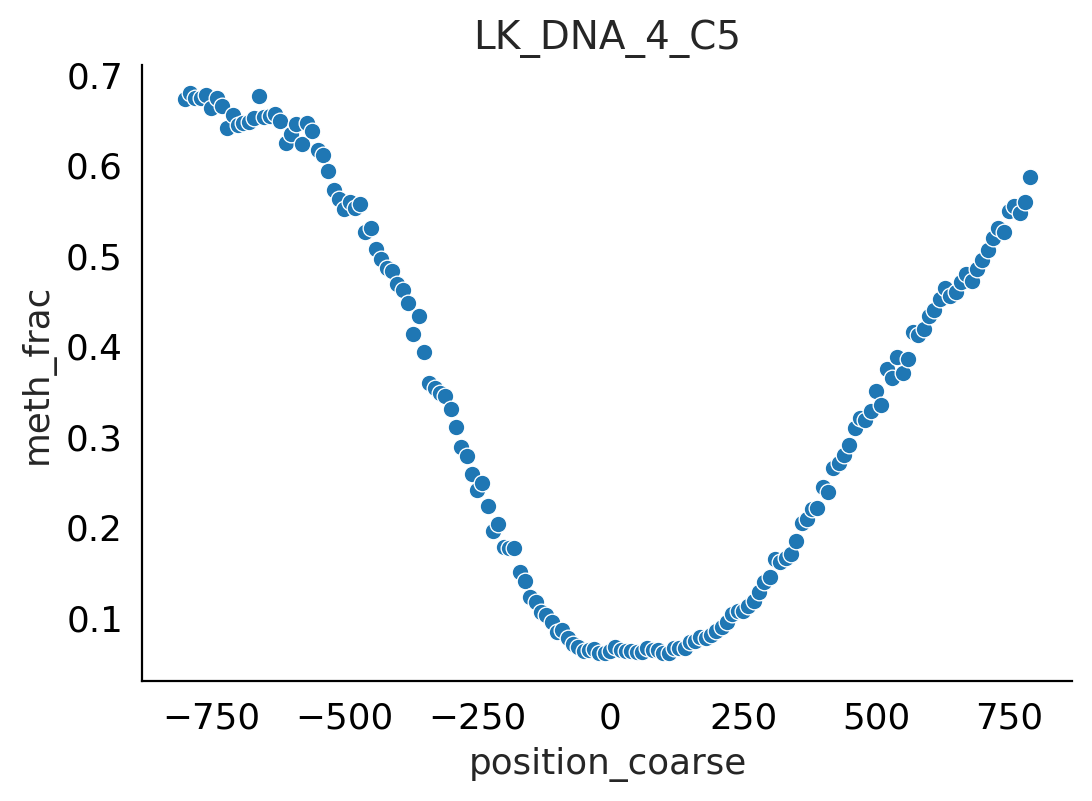

In [8]:
df_sample = methyltree.metadata.load_sample_info(data_path)
SampleList = df_sample["sample"].to_numpy()
for sample in SampleList[:5]:
    plt.figure()
    sns.scatterplot(data=df_TSS_new[df_TSS_new['cell_name']==sample],x='position_coarse',y='meth_frac')
    plt.title(sample)

In [9]:
category_key='plate_id'
df_stats[category_key]=df_stats['sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))

In [10]:
df_stats[category_key].value_counts()

LK_DNA_1    96
LK_DNA_2    96
LK_DNA_3    96
LK_DNA_4    96
LK_DNA_5    96
LK_DNA_6    96
Name: plate_id, dtype: int64

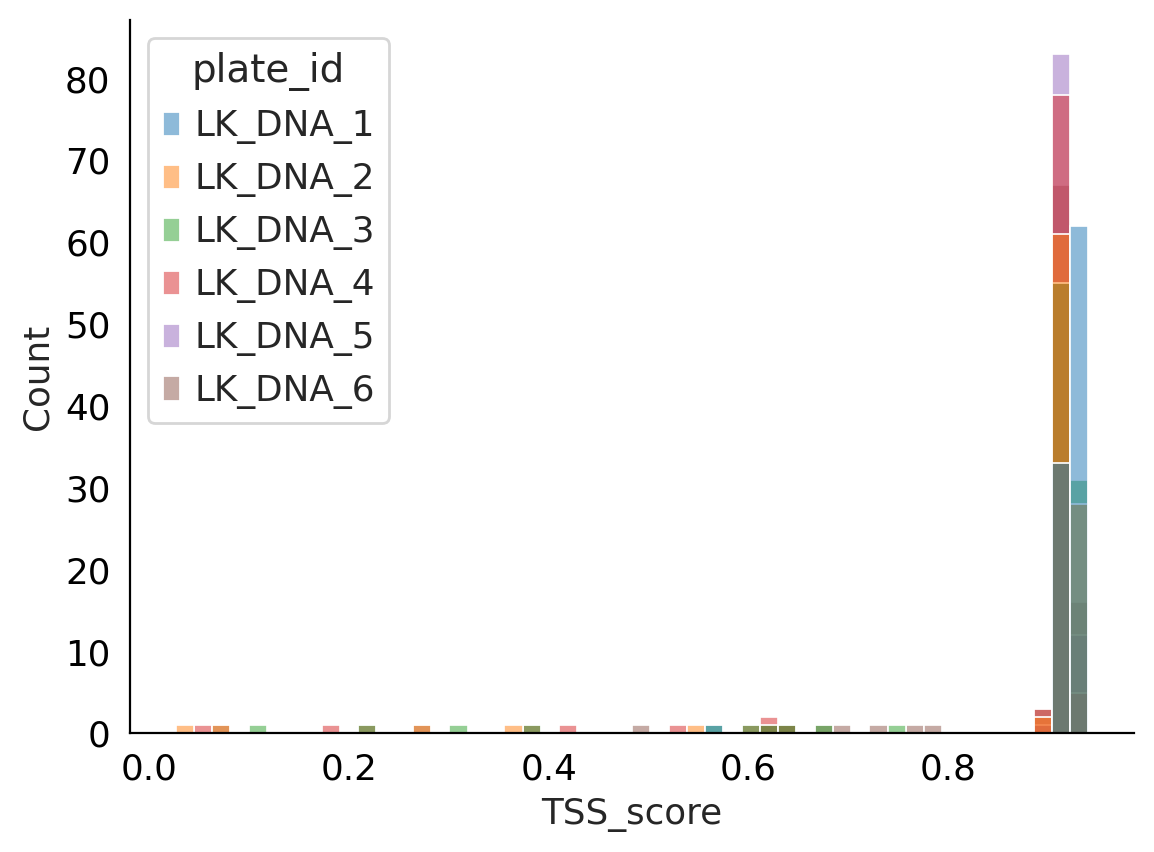

In [11]:
fig,axs=plt.subplots(1,1,figsize=(6,4.5))
sns.histplot(data=df_stats,x='TSS_score',hue=category_key,bins=50)
plt.tight_layout()

In [12]:
# Define QC threshold
nCG_cutoff=5*10**5
TSS_score_cutoff=0.7
#df_stats['met_rate']=df_stats['met_Nmet_reads']/df_stats['met_N_tot_reads']
df_stats['pass_metQC']=(df_stats['nCG']>nCG_cutoff) & (df_stats['TSS_score']>TSS_score_cutoff)
df_stats['HQ']=df_stats['pass_metQC'] #& df_stats['pass_accQC'] #(df_stats['nCG']>nCG_cutoff) & (df_stats['nGC']>nGC_cutoff)  & (df_stats['corr_acc']<-0.5) # & (df_stats['acc_rate']>0.05) 

In [13]:
for plate_id in list(set(df_stats['plate_id'])):
    print(f'------------{plate_id}-----------')
    df_C_tmp=df_stats[df_stats['plate_id']==plate_id]
    print('Fraction that pass {y} CpG: {x}'.format(y=nCG_cutoff,x=(df_C_tmp['nCG']>nCG_cutoff).mean()))
    #print('Fraction that pass {y} GpC: {x}'.format(y=nGC_cutoff,x=(df_C_tmp['nGC']>nGC_cutoff).mean()))
    #print('Fraction that pass profile QC (acc): {x}'.format(x=(df_C_tmp['corr_acc']<corr_acc_cutoff).mean()))
    #print('Fraction that pass profile QC (met): {x}'.format(x=(df_C_tmp['TSS_score']>TSS_score_cutoff).mean()))
    #print('Fraction that pass profile QC (acc-met): {x}'.format(x=(df_C_tmp['corr_met_acc']<-0.5).mean()))
    print('Fraction that pass all QC: {x}'.format(x=df_C_tmp['HQ'].mean()))
    print('Number of cells passing all QC: {x}'.format(x=df_C_tmp['HQ'].sum()))
    
print('Total cells passing all QC: {x}'.format(x=df_stats['HQ'].sum()))

------------LK_DNA_2-----------
Fraction that pass 500000 CpG: 0.9479166666666666
Fraction that pass all QC: 0.9479166666666666
Number of cells passing all QC: 91
------------LK_DNA_6-----------
Fraction that pass 500000 CpG: 0.8958333333333334
Fraction that pass all QC: 0.8958333333333334
Number of cells passing all QC: 86
------------LK_DNA_5-----------
Fraction that pass 500000 CpG: 1.0
Fraction that pass all QC: 1.0
Number of cells passing all QC: 96
------------LK_DNA_1-----------
Fraction that pass 500000 CpG: 0.9895833333333334
Fraction that pass all QC: 0.9895833333333334
Number of cells passing all QC: 95
------------LK_DNA_4-----------
Fraction that pass 500000 CpG: 0.8854166666666666
Fraction that pass all QC: 0.8854166666666666
Number of cells passing all QC: 85
------------LK_DNA_3-----------
Fraction that pass 500000 CpG: 0.8958333333333334
Fraction that pass all QC: 0.8958333333333334
Number of cells passing all QC: 86
Total cells passing all QC: 539


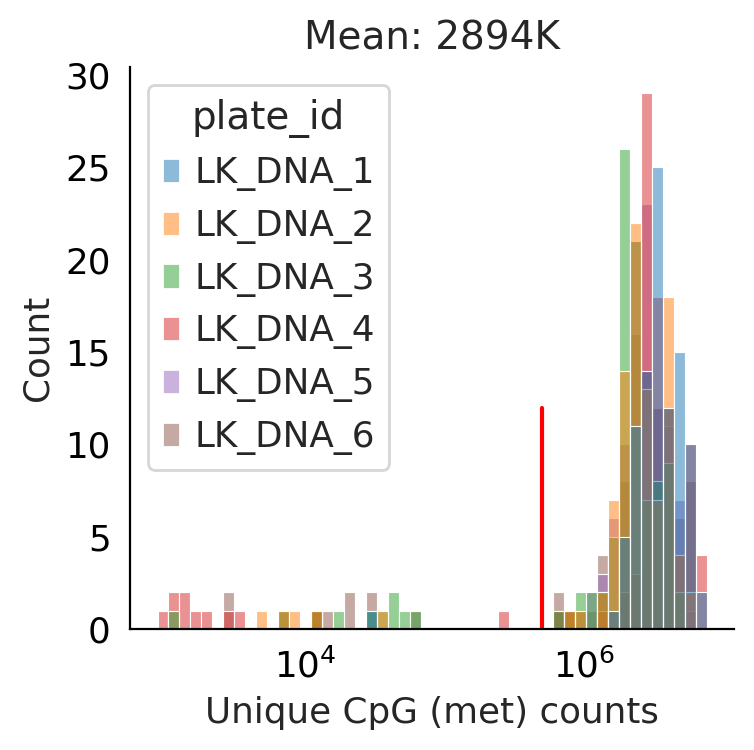

In [14]:
# select cells for visualization if needed 
df_C_tmp=df_stats
fig,axs=plt.subplots(1,1,figsize=(4,4))
ax=sns.histplot(data=df_C_tmp,x='nCG',ax=axs,log_scale=True,bins=50,hue=category_key)
ax.plot([nCG_cutoff,nCG_cutoff],[0,12],'-r')
ax.set_xlabel('Unique CpG (met) counts')
ax.set_title(f'Mean: {df_C_tmp.nCG.mean()/1000:.0f}K')
plt.tight_layout()

In [15]:
df_stats.groupby(category_key).agg('mean')

,nCG,n_meth,met_rate,TSS_score,pass_metQC,HQ
plate_id,,,,,,
LK_DNA_1,3.655679e+06,2.572982e+06,0.708386,0.919897,0.989583,0.989583
LK_DNA_2,2.682741e+06,1.853740e+06,0.705551,0.884272,0.947917,0.947917
LK_DNA_3,2.174339e+06,1.527138e+06,0.720795,0.874300,0.895833,0.895833
LK_DNA_4,3.213719e+06,2.261550e+06,0.700086,0.863769,0.885417,0.885417
LK_DNA_5,2.860792e+06,2.015291e+06,0.706693,0.916232,1.000000,1.000000
LK_DNA_6,2.774970e+06,1.941800e+06,0.711315,0.880121,0.895833,0.895833


In [16]:
df_stats

,sample,nCG,n_meth,met_rate,TSS_score,plate_id,pass_metQC,HQ
0,LK_DNA_1_A1,5823675,4095711,0.703286,0.923478,LK_DNA_1,True,True
1,LK_DNA_1_A10,4263579,3009624,0.705891,0.922159,LK_DNA_1,True,True
2,LK_DNA_1_A11,3621097,2649970,0.731814,0.917180,LK_DNA_1,True,True
3,LK_DNA_1_A12,3732135,2347085,0.628885,0.933875,LK_DNA_1,True,True
4,LK_DNA_1_A2,3555247,2637749,0.741931,0.924622,LK_DNA_1,True,True
...,...,...,...,...,...,...,...,...
571,LK_DNA_6_H5,5418277,3722361,0.687001,0.920856,LK_DNA_6,True,True
572,LK_DNA_6_H6,5426532,3677126,0.677620,0.918820,LK_DNA_6,True,True
573,LK_DNA_6_H7,3341204,2177420,0.651687,0.924902,LK_DNA_6,True,True
574,LK_DNA_6_H8,4213937,2892398,0.686389,0.922848,LK_DNA_6,True,True


# Other metrics

In [17]:
df_chr_rate,df_chr_nCG=methyltree.quality_control.generate_chr_stats(compact_file_dir)
df_chr_rate_sub=df_chr_rate.filter([x for x in df_chr_rate.columns if x.startswith('chr') and (x not in ['chrX','chrY','chrM'])])
df_chr_rate_sub=df_chr_rate.rename(columns={'lambda_NEB':'lambda','L09137':'pUC19'}).filter(['chrM','lambda','pUC19'])
df_chr_rate_sub.columns=[f'{x}_rate' for x in df_chr_rate_sub.columns]
df_stats_v1=pd.concat([df_stats,df_chr_rate_sub],axis=1)

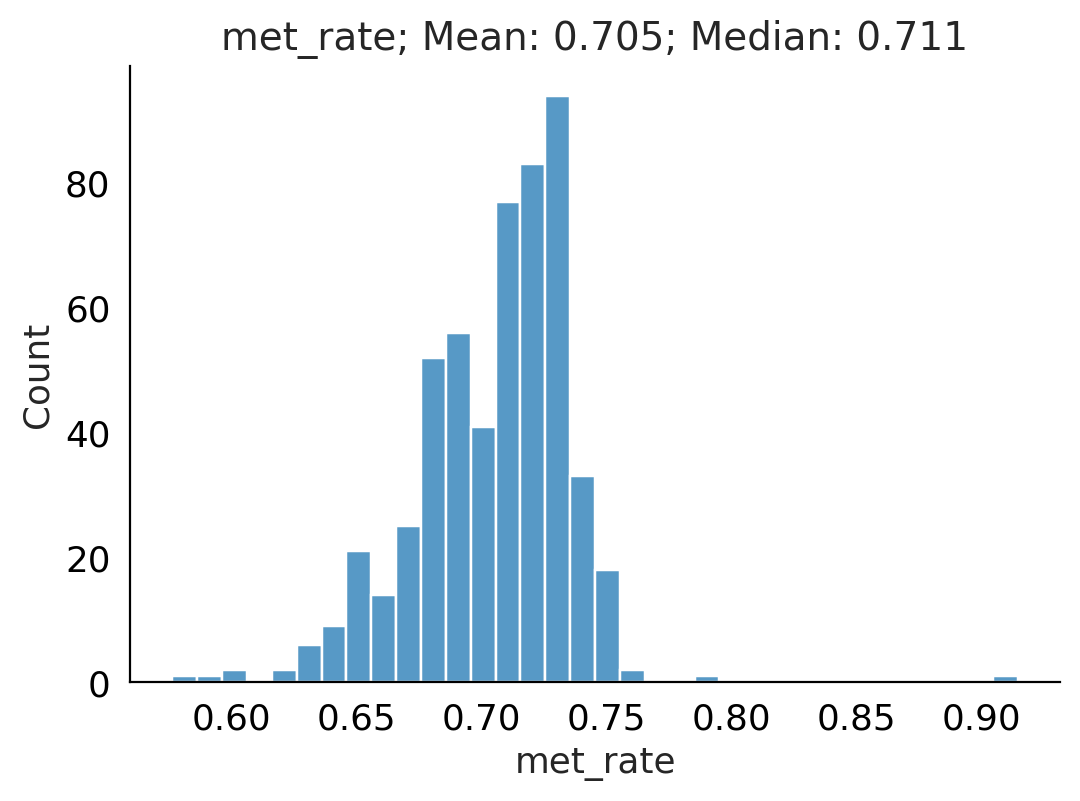

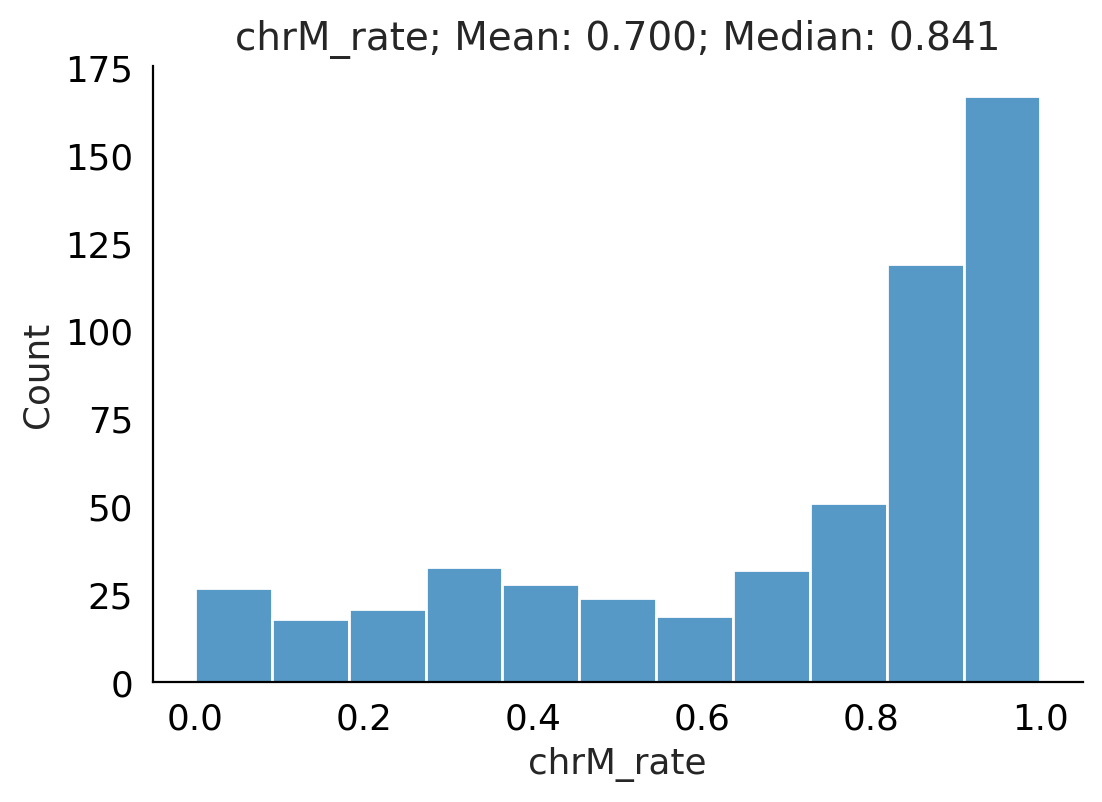

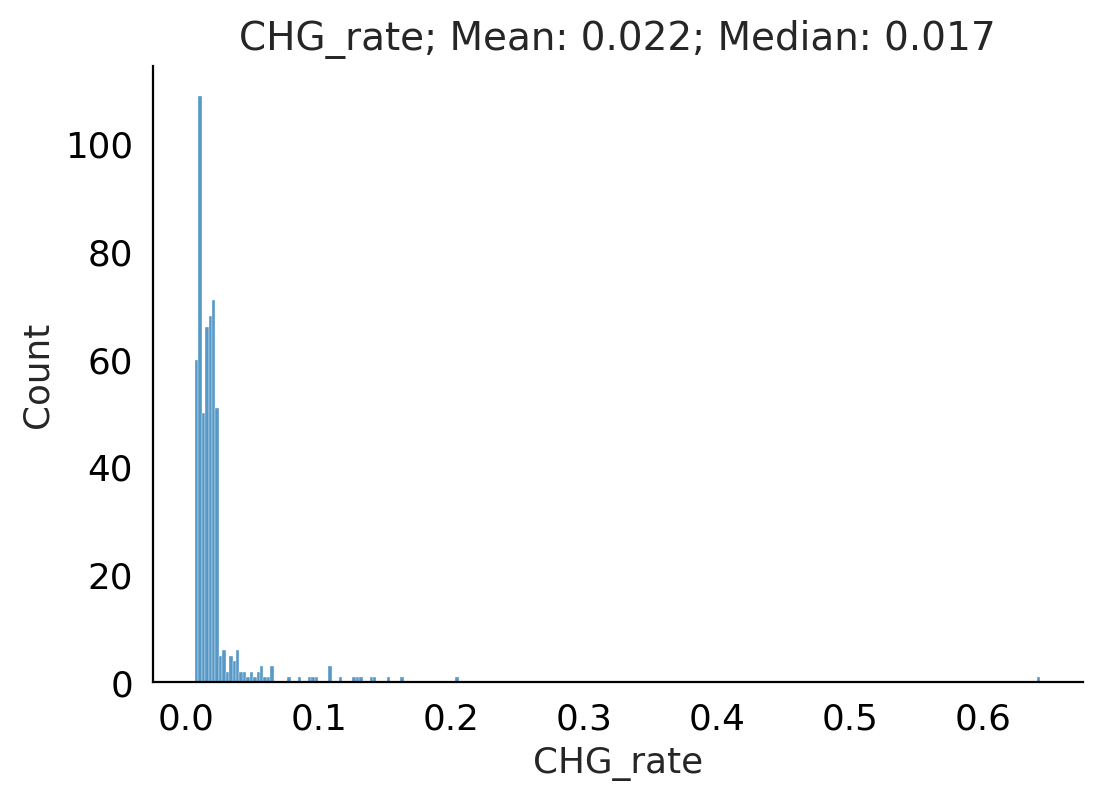

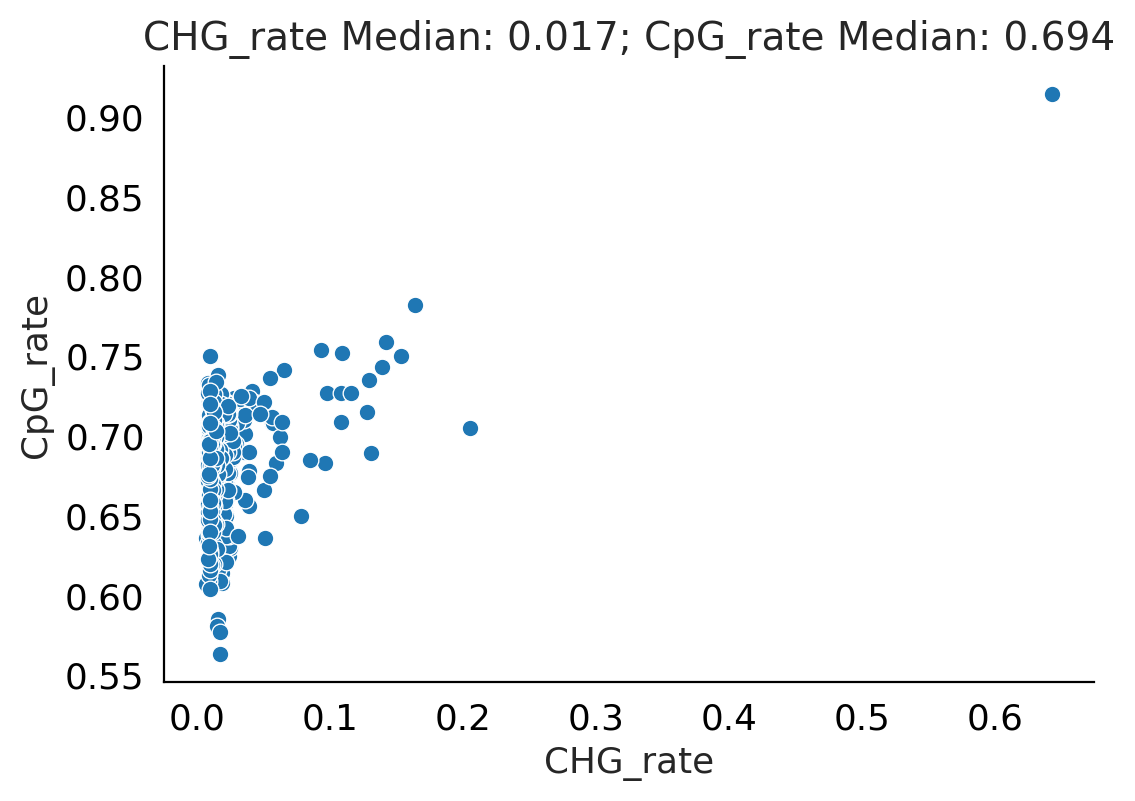

In [18]:
from methyltree import quality_control as meq
df_rate = meq.QC_CpG_CHG_CHH_rate(data_path,mapping_mode=mapping_mode)
for x in ['CHG_rate','CpG_rate','CHH_rate']:
    df_rate[x]=df_rate[x]/100
df_stats_v1=df_stats_v1.set_index('sample')
df_rate=df_rate.set_index('sample')
for col in df_rate.columns:
    df_stats_v1[col]=df_rate[col]
df_stats_v1=df_stats_v1.reset_index()
df_rate=df_rate.reset_index()

df_sub=df_stats_v1[df_stats_v1['HQ']]  
for x in ['met_rate','lambda_rate','chrM_rate','puc19_rate','CHG_rate']:
    if x in df_stats_v1.columns:
        if np.sum(~pd.isna(df_sub[x]))>0:
            sns.histplot(data=df_sub,x=x)
            mean_x=df_sub[x].mean()
            median_x=df_sub[x].median()
            plt.title(f'{x}; Mean: {mean_x:.3f}; Median: {median_x:.3f}')
            plt.show()
        
for (x,y) in [('CHG_rate','CpG_rate'),('lambda_rate','puc19_rate'),('lambda_rate','CHG_rate')]:
    if (x in df_stats_v1.columns) and (y in df_stats_v1.columns):
        if (np.sum(~pd.isna(df_sub[x]))>0) and (np.sum(~pd.isna(df_sub[y]))>0):
            plt.subplots()
            sns.scatterplot(data=df_sub,x=x,y=y)
            x_median=df_sub[x].median()
            y_median=df_sub[y].median()
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title(f'{x} Median: {x_median:.3f}; {y} Median: {y_median:.3f}')
            plt.show()

In [19]:
df_stats_v1

,sample,nCG,n_meth,met_rate,TSS_score,plate_id,pass_metQC,HQ,chrM_rate,CpG_rate,CHG_rate,CHH_rate
0,LK_DNA_1_A1,5823675,4095711,0.703286,0.923478,LK_DNA_1,True,True,0.842105,0.676,0.019,0.022
1,LK_DNA_1_A10,4263579,3009624,0.705891,0.922159,LK_DNA_1,True,True,0.915691,0.675,0.020,0.023
2,LK_DNA_1_A11,3621097,2649970,0.731814,0.917180,LK_DNA_1,True,True,0.782609,0.712,0.019,0.021
3,LK_DNA_1_A12,3732135,2347085,0.628885,0.933875,LK_DNA_1,True,True,0.954327,0.611,0.018,0.020
4,LK_DNA_1_A2,3555247,2637749,0.741931,0.924622,LK_DNA_1,True,True,0.927885,0.724,0.022,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...
571,LK_DNA_6_H5,5418277,3722361,0.687001,0.920856,LK_DNA_6,True,True,0.567073,0.653,0.010,0.011
572,LK_DNA_6_H6,5426532,3677126,0.677620,0.918820,LK_DNA_6,True,True,0.445748,0.640,0.010,0.012
573,LK_DNA_6_H7,3341204,2177420,0.651687,0.924902,LK_DNA_6,True,True,0.281984,0.631,0.009,0.011
574,LK_DNA_6_H8,4213937,2892398,0.686389,0.922848,LK_DNA_6,True,True,0.332410,0.660,0.010,0.012


## df_sample

In [20]:
df_tmp=df_stats_v1.set_index('sample') #.drop(['source_x','source_y'],axis=1).set_index('sample')
df_mapping_tmp=df_mapping.filter(['Mapping_all','sample']).rename(columns={'Mapping_all':'Mapping_efficiency'}).set_index('sample')
df_sample_tmp=df_sample.set_index('sample')
for col in df_tmp.columns:
    df_sample_tmp[col]=df_tmp[col]
    
for col in df_mapping_tmp.columns:
    df_sample_tmp[col]=df_mapping_tmp[col]

# get rid of NAN
df_sample_tmp=df_sample_tmp.reset_index()
df_sample_tmp=df_sample_tmp[df_sample_tmp['sample'].isin(df_stats_v1['sample'])]
df_sample_tmp['tissue']=df_sample_tmp['sample'].apply(lambda x: x.split('_')[0])
methyltree.metadata.backup_and_save_sample_info(df_sample_tmp,data_path)

In [21]:
df_sample=methyltree.metadata.load_sample_info(data_path)

In [22]:
df_sample

,sample,cell,pass_accQC,pass_metQC,id_met,id_acc,lineage,stage,nCG,n_meth,met_rate,TSS_score,plate,HQ,plate_id,chrM_rate,CpG_rate,CHG_rate,CHH_rate,Mapping_efficiency,tissue
0,LK_DNA_5_H9,LK_DNA_5_H9,True,True,LK_DNA_5_H9,LK_DNA_5_H9,1,1,2075673,1511563,0.728228,0.908107,LK_DNA_5,True,LK_DNA_5,0.861650,0.716,0.013,0.017,73.3,LK
1,LK_DNA_5_A5,LK_DNA_5_A5,True,True,LK_DNA_5_A5,LK_DNA_5_A5,1,1,3501890,2230074,0.636820,0.910036,LK_DNA_5,True,LK_DNA_5,0.900966,0.619,0.011,0.015,78.0,LK
2,LK_DNA_4_G1,LK_DNA_4_G1,True,True,LK_DNA_4_G1,LK_DNA_4_G1,1,1,2849573,2100948,0.737285,0.917175,LK_DNA_4,True,LK_DNA_4,0.175385,0.720,0.012,0.015,78.1,LK
3,LK_DNA_4_B11,LK_DNA_4_B11,True,True,LK_DNA_4_B11,LK_DNA_4_B11,1,1,3132710,2302420,0.734961,0.921085,LK_DNA_4,True,LK_DNA_4,0.044199,0.714,0.008,0.010,75.8,LK
4,LK_DNA_4_C5,LK_DNA_4_C5,True,True,LK_DNA_4_C5,LK_DNA_4_C5,1,1,5708395,4110959,0.720160,0.912996,LK_DNA_4,True,LK_DNA_4,0.184343,0.695,0.019,0.021,81.4,LK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,LK_DNA_1_E11,LK_DNA_1_E11,True,True,LK_DNA_1_E11,LK_DNA_1_E11,1,1,2541948,1742106,0.685343,0.926385,LK_DNA_1,True,LK_DNA_1,0.923267,0.672,0.020,0.022,66.1,LK
572,LK_DNA_2_D8,LK_DNA_2_D8,True,True,LK_DNA_2_D8,LK_DNA_2_D8,1,1,1708331,1224884,0.717006,0.908287,LK_DNA_2,True,LK_DNA_2,0.938172,0.712,0.056,0.057,69.8,LK
573,LK_DNA_3_H2,LK_DNA_3_H2,True,True,LK_DNA_3_H2,LK_DNA_3_H2,1,1,2538646,1797874,0.708202,0.914139,LK_DNA_3,True,LK_DNA_3,0.899497,0.690,0.027,0.028,59.8,LK
574,LK_DNA_2_E3,LK_DNA_2_E3,True,True,LK_DNA_2_E3,LK_DNA_2_E3,1,1,2047027,1403202,0.685483,0.925042,LK_DNA_2,True,LK_DNA_2,0.957286,0.675,0.018,0.020,65.6,LK


## Data consistency

In [23]:
df_chr_rate,df_chr_nCG=methyltree.quality_control.generate_chr_stats(compact_file_dir)
df_chr_rate_sub=df_chr_rate.filter([x for x in df_chr_rate.columns if x.startswith('chr') and (x not in ['chrX','chrY','chrM'])])
adata = sc.AnnData(df_chr_rate_sub.to_numpy())
adata.obs_names=df_stats['sample']
methyltree.analysis.update_sample_info_on_adata(adata,df_sample)
adata=adata[adata.obs['HQ']]

LK_DNA_1_A1


Text(0, 0.5, 'Met rate (cell-2)')

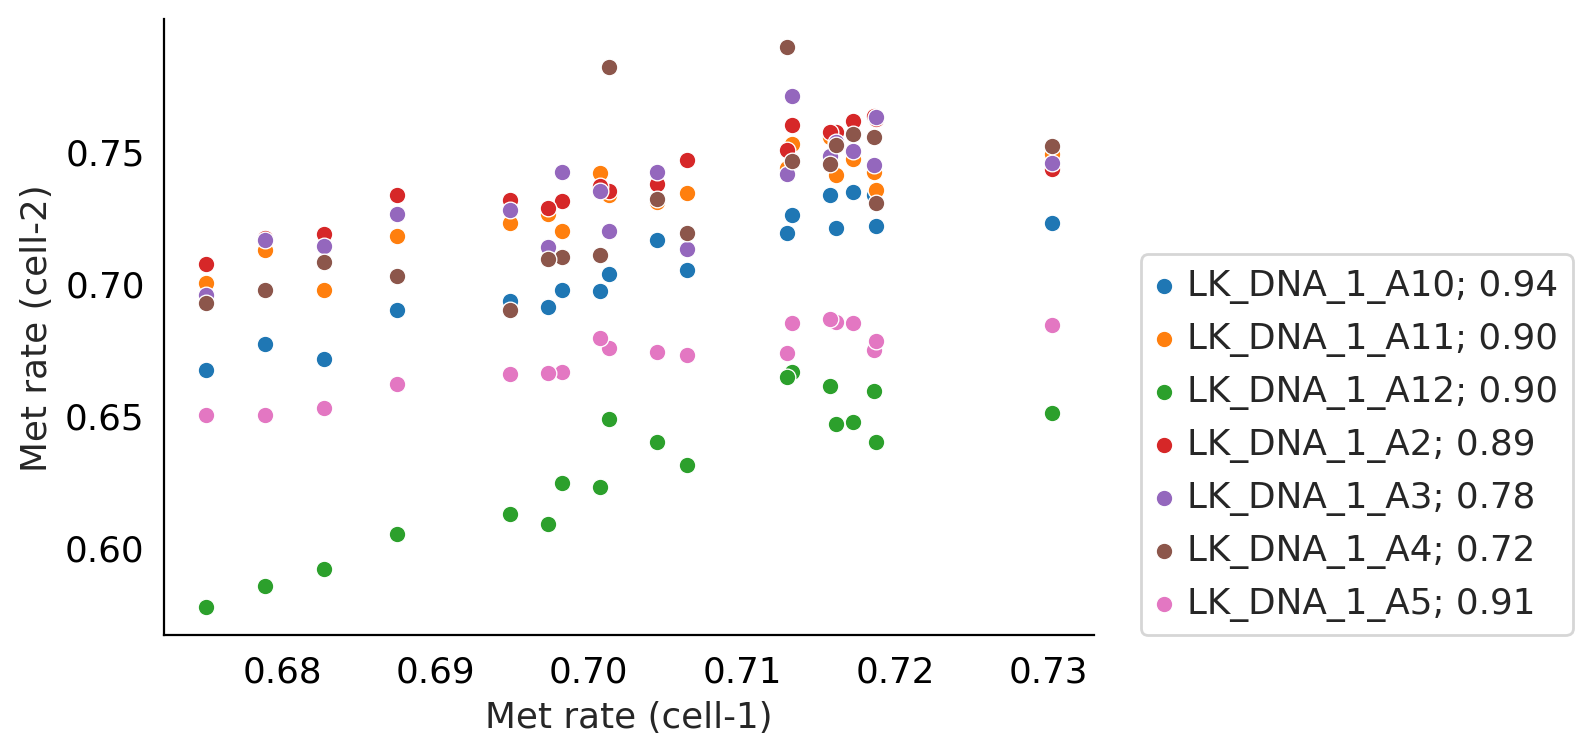

In [24]:
ko=0
print(adata.obs_names[ko])
for j in range(7):
    sns.scatterplot(adata.X[ko],adata.X[j+1+ko],label=f'{adata.obs_names[ko+j+1]}; {np.corrcoef(adata.X[ko],adata.X[ko+j+1])[0,1]:.2f}')
plt.legend(loc=[1.05,0])
plt.xlabel('Met rate (cell-1)')
plt.ylabel('Met rate (cell-2)')

Use correlation for similarity
duration: 6.454087972640991


Text(0.5, 0, 'Cell-Cell similarity')

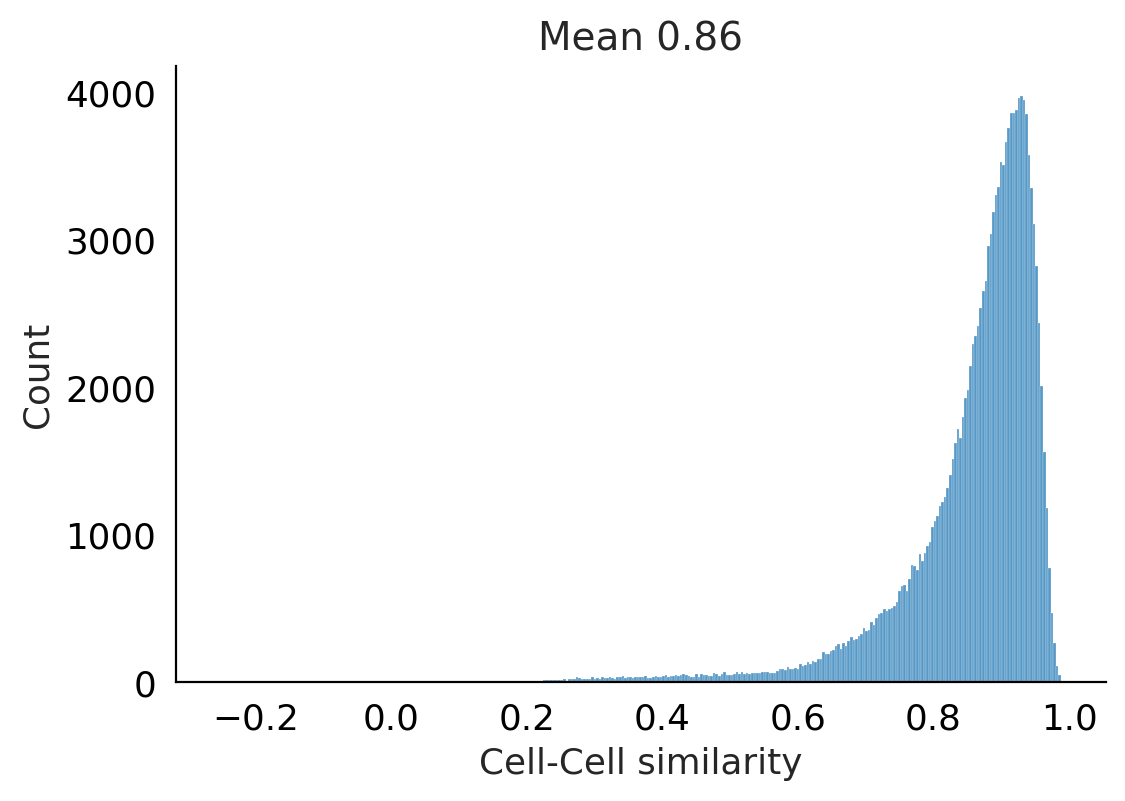

In [25]:
X_similarity,_=methyltree.ana.compute_similarity_matrix(adata.X)
off_diag=X_similarity[np.triu_indices_from(X_similarity,k=1)]
sns.histplot(off_diag)
plt.title(f'Mean {off_diag.mean():.2f}')
plt.xlabel('Cell-Cell similarity')